In [4]:
import bayesflow as bf
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import torch
from torch.distributions import Normal, Independent,InverseGamma


In [5]:

def prior_fun(batch_size=1):
    #  N(mean, stddev)
    mean, stddev = 0.0, 1.0
    miu_dist = tfp.distributions.Normal(mean, stddev)
    miu_samples = tf.cast(miu_dist.sample(batch_size), dtype=tf.float32)

    #  InverseGamma(alpha, beta)
    alpha, beta = 2.0, 1.0
    sigma2_dist = tfp.distributions.InverseGamma(concentration=alpha, scale=beta)
    sigma2_samples = tf.cast(sigma2_dist.sample(batch_size), dtype=tf.float32)
    
    # (batch_size, 2) 
    return tf.concat([miu_samples[:, None], sigma2_samples[:, None]], axis=-1)


def likelihood_fun(params, n_obs=1000):
    miu = params[:, 0]  #  miu
    sigma2 = params[:, 1]  #  sigma^2
    return tf.random.normal(
        shape=(params.shape[0], n_obs, 1),
        mean=miu[:, None],
        stddev=tf.sqrt(sigma2)[:, None]
    )

In [6]:

prior = bf.simulation.Prior(prior_fun=prior_fun)
simulator = bf.simulation.Simulator(simulator_fun=likelihood_fun)
model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator)

summary_net = bf.networks.DeepSet(summary_dim=10)

inference_net = bf.networks.InvertibleNetwork(
    num_params=2,
    num_coupling_layers=4,
)


amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)

# configurator
def custom_configurator(simulation_outputs):
    prior_draws = simulation_outputs['prior_draws']
    transformed_sigma2 = tf.math.log(prior_draws[:,:,1:2])

    transformed_params = tf.concat([prior_draws[:,:,0:1], transformed_sigma2], axis=-1)

    configured_outputs = {
        'parameters': transformed_params,          
        'summary_conditions': simulation_outputs['sim_data'],  
        'direct_conditions': None
    }
    return configured_outputs
 

trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=custom_configurator 
)

history = trainer.train_online(
    epochs=5,
    iterations_per_epoch=500,
    batch_size=32,
    validation_sims=200
)


INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1, 1000, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
INFO:root:Generated 200 simulations for validation.
Training epoch 1: 100%|██████████| 500/500 [01:15<00:00,  6.58it/s, Epoch: 1, Iter: 500,Loss: -0.620,W.Decay: 0.156,Avg.Loss: 0.846,Avg.W.Decay: 0.164,LR: 4.52E-04]
INFO:root:Validation, Epoch: 1, Loss: -0.254
Training epoch 2: 100%|██████████| 500/500 [01:13<00:00,  6.83it/s, Epoch: 2, Iter: 500,Loss: -2.649,W.Decay: 0.152,Avg.Loss: -1.855,Avg.W.Decay: 0.154,LR: 3.28E-04]
INFO:r

In [7]:

n_obs = 1000  
true_miu = 0 
true_sigma = 0.3  
obs_data = np.random.normal(loc=true_miu, scale=true_sigma, size=(n_obs, 1)).astype(np.float32)
Z = obs_data  #  NumPy 
obs_data = obs_data[np.newaxis, :, :]  # (1, n_obs, 1)

posterior_samples = amortizer.sample({"summary_conditions": obs_data}, n_samples=1000)

In [8]:
posterior_samples

array([[-0.06004567, -2.3185027 ],
       [ 0.75058615, -2.1510673 ],
       [ 0.04213702, -2.3919952 ],
       ...,
       [ 0.3588097 , -2.1913314 ],
       [ 0.11209941, -2.4133596 ],
       [-0.27607352, -2.5657945 ]], dtype=float32)

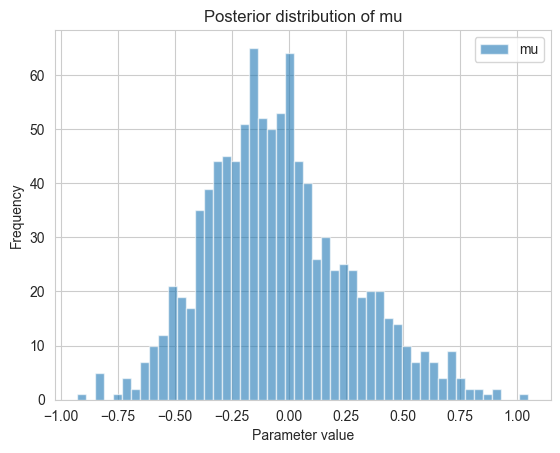

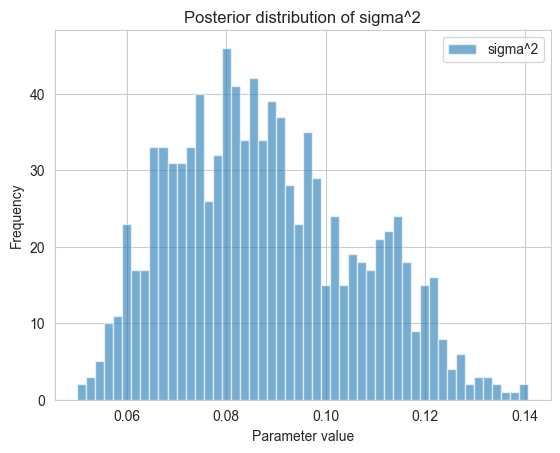

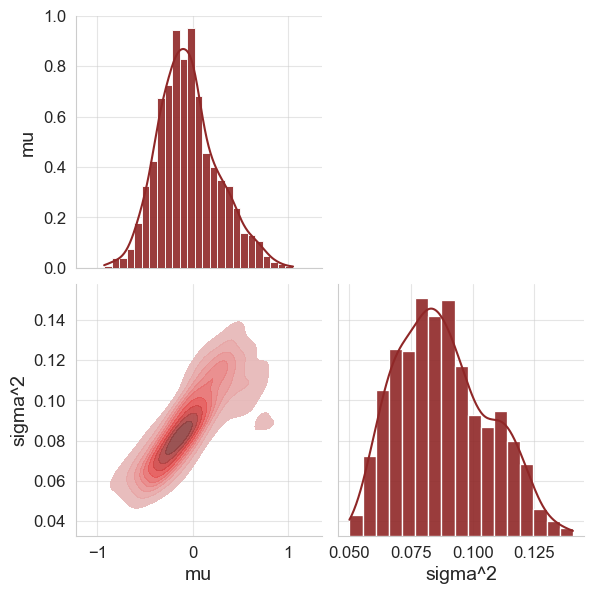

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Parameter names
param_names = ["mu", "sigma^2"]

# Transform the second parameter (variance) from log scale to standard scale
posterior_samples[:, 1] = np.exp(posterior_samples[:, 1])

# Plot histograms of the posterior distribution for each parameter
for i in range(posterior_samples.shape[1]):  # Iterate over mu and sigma^2
    plt.hist(posterior_samples[:, i], bins=50, alpha=0.6, label=f"{param_names[i]}")
    plt.xlabel("Parameter value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(f"Posterior distribution of {param_names[i]}")
    plt.show()

# Use diagnostic tools to plot the joint posterior distribution
f = bf.diagnostics.plot_posterior_2d(posterior_samples, param_names=param_names)


In [10]:
posterior_samples

array([[-0.06004567,  0.09842084],
       [ 0.75058615,  0.1163599 ],
       [ 0.04213702,  0.09144705],
       ...,
       [ 0.3588097 ,  0.11176784],
       [ 0.11209941,  0.08951405],
       [-0.27607352,  0.0768581 ]], dtype=float32)

In [11]:
import numpy as np

# Prior parameters
mu_0 = 0
sigma_0_sq = 1  # Prior variance
alpha_0 = 2
beta_0 = 1  # Prior scale parameter

# Sample mean and sample size
Y_mean = np.mean(Z)  # Sample mean
n = n_obs  # Sample size

# Calculate total sample variance
variance = np.sum((Z - Y_mean) ** 2)  # Total variance

kappa_0 = 1
kappa_n = kappa_0 + n

# Posterior parameter calculations
# Posterior for sigma^2
alpha_poster = alpha_0 + n / 2
beta_poster = beta_0 + 0.5 * variance + kappa_0 * n * (Y_mean - mu_0) ** 2 / (2 * kappa_n)

# Posterior for mu
sigma_poster_sq = sigma_0_sq / (kappa_0 + n)  # Posterior variance
mu_poster = (kappa_0 * mu_0 + n * Y_mean) / kappa_n  # Posterior mean

# Output results
print("Posterior alpha:", alpha_poster)
print("Posterior beta:", beta_poster)
print("Posterior mu (mean):", mu_poster)
print("Posterior sigma^2 (variance):", sigma_poster_sq)


Posterior alpha: 502.0
Posterior beta: 48.17243870785645
Posterior mu (mean): -0.010964279244472455
Posterior sigma^2 (variance): 0.000999000999000999


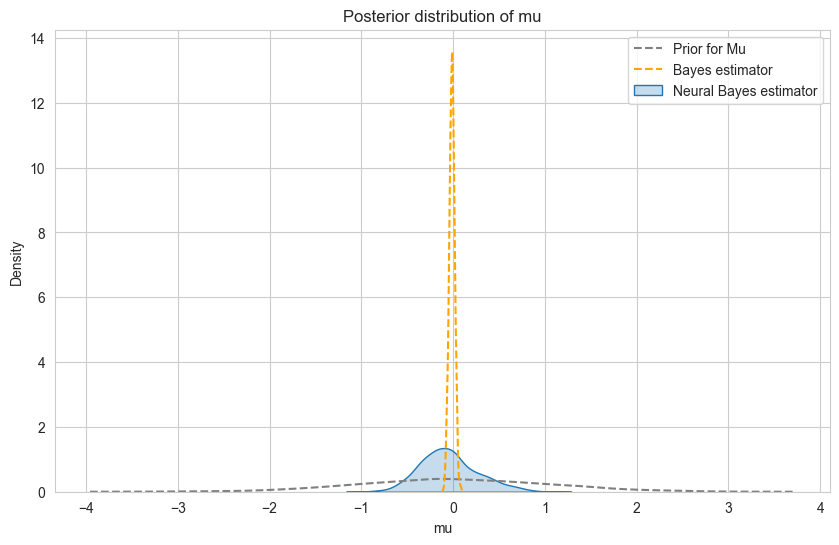

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set parameters for the prior distribution
mu_prior = 0  # Mean
sigma_prior = 1  # Standard deviation

# Define the prior distribution
dist = tfp.distributions.Normal(loc=0, scale=1)

# Sample from the prior distribution
prior_samples = dist.sample(1000).numpy()

sns.kdeplot(prior_samples, label="Prior for Mu", color="grey", linestyle="--")

# Calculate the posterior standard deviation
sigma_poster = np.sqrt(sigma_poster_sq)

# Define the posterior distribution
dist = tfp.distributions.Normal(loc=mu_poster, scale=sigma_poster)

# Sample from the posterior distribution
reference = dist.sample(1000).numpy()
sns.kdeplot(reference, label="Bayes estimator", color="orange", linestyle="--")

# Parameter names
param_names = ["mu", "sigma^2"]

sns.kdeplot(posterior_samples[:, 0], label="Neural Bayes estimator", fill=True)
plt.xlabel(param_names[0])
plt.ylabel("Density")
plt.title(f"Posterior distribution of {param_names[0]}")
plt.legend()
plt.show()


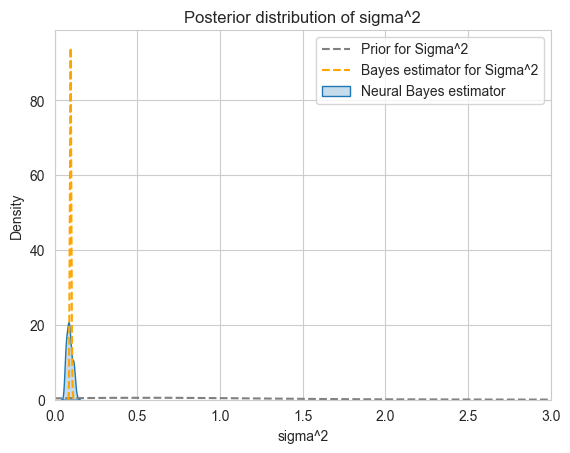

In [13]:
# sigma_poster_samples = np.exp(posterior_samples[:, 1])

# Define the prior distribution
dist = tfp.distributions.InverseGamma(concentration=2, scale=1) 
prior_samples = dist.sample(1000).numpy()
sns.kdeplot(prior_samples, label="Prior for Sigma^2", color="grey", linestyle="--")

# Define the posterior distribution
dist = tfp.distributions.InverseGamma(concentration=alpha_poster, scale=beta_poster)
poster_samples = dist.sample(1000).numpy()
sns.kdeplot(poster_samples, label="Bayes estimator for Sigma^2", color="orange", linestyle="--")

# Set x-axis range
plt.xlim(0, 3)

param_names = ["mu", "sigma^2"]
sns.kdeplot(posterior_samples[:, 1], label="Neural Bayes estimator", fill=True)
plt.xlabel(param_names[1])
plt.ylabel("Density")
plt.title(f"Posterior distribution of {param_names[1]}")
plt.legend()
plt.show()


Restrict to a subset: only miu

In [14]:

prior = bf.simulation.Prior(prior_fun=prior_fun)
simulator = bf.simulation.Simulator(simulator_fun=likelihood_fun)
model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator)

# 定义总结网络
summary_net = bf.networks.DeepSet(summary_dim=10)

inference_net = bf.networks.InvertibleNetwork(
    num_params=1, # need change
    num_coupling_layers=4,
)

amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)

# configurator
def custom_configurator(simulation_outputs):
    prior_draws = simulation_outputs['prior_draws']
    configured_outputs = {
        'parameters': prior_draws[:,:,0:1].astype(np.float32), #only for miu
        'summary_conditions': simulation_outputs['sim_data'].astype(np.float32), 
    }
    return configured_outputs

trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=custom_configurator
)

history = trainer.train_online(
    epochs=1,
    iterations_per_epoch=500,
    batch_size=32,
    validation_sims=200
)


INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1, 1000, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
INFO:root:Generated 200 simulations for validation.
Training epoch 1: 100%|██████████| 500/500 [01:29<00:00,  5.60it/s, Epoch: 1, Iter: 500,Loss: -1.332,W.Decay: 0.144,Avg.Loss: -0.363,Avg.W.Decay: 0.153,LR: 4.93E-09]
INFO:root:Validation, Epoch: 1, Loss: -1.552


In [15]:
# 1. Generate true data
# Assume the true data is generated from a N(0, 1) distribution
n_obs = 1000  # Number of samples
true_miu = 10  # True mean
true_sigma = 0.3  # True standard deviation
obs_data = np.random.normal(loc=true_miu, scale=true_sigma, size=(n_obs, 1)).astype(np.float32)
Z = obs_data  # If PyTorch tensor, convert to NumPy array
obs_data = obs_data[np.newaxis, :, :]  # Reshape to (1, n_obs, 1)

# Sample from the posterior using the amortizer
posterior_samples = amortizer.sample({"summary_conditions": obs_data}, n_samples=1000)


In [16]:
posterior_samples

array([[7.137333 ],
       [6.9658093],
       [6.916664 ],
       [6.9467154],
       [7.022731 ],
       [6.8958206],
       [6.784378 ],
       [6.774108 ],
       [6.8593135],
       [6.744903 ],
       [7.0255885],
       [6.82298  ],
       [7.026948 ],
       [7.134646 ],
       [6.7698517],
       [6.871041 ],
       [6.8462896],
       [6.901065 ],
       [6.919862 ],
       [6.874867 ],
       [7.031898 ],
       [6.8111615],
       [7.0876517],
       [6.74839  ],
       [7.0290165],
       [6.609659 ],
       [6.9279857],
       [7.0772114],
       [6.880983 ],
       [7.3016367],
       [6.9689617],
       [6.9614115],
       [6.9569573],
       [6.8890395],
       [7.032708 ],
       [6.832644 ],
       [6.8769546],
       [6.9083476],
       [6.991145 ],
       [6.889349 ],
       [6.853649 ],
       [7.1722817],
       [7.005945 ],
       [7.0714903],
       [7.146975 ],
       [7.0709653],
       [7.1603146],
       [6.889829 ],
       [6.7993255],
       [7.0523643],


In [17]:
test_output = model(batch_size=5) 
configured_output = custom_configurator(test_output)

print("Original prior_draws:", test_output['prior_draws'])
print("Configured parameters:", configured_output['parameters'])
print("Shape of configured parameters:", configured_output['parameters'].shape)

Original prior_draws: [[[ 0.10728988  0.47304243]]

 [[-0.2618002   0.39052758]]

 [[-0.21511462  0.607883  ]]

 [[-0.20204052  0.24775866]]

 [[ 0.50241995  0.91295284]]]
Configured parameters: [[[ 0.10728988]]

 [[-0.2618002 ]]

 [[-0.21511462]]

 [[-0.20204052]]

 [[ 0.50241995]]]
Shape of configured parameters: (5, 1, 1)
